In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import torch


#Loading training data

In [2]:
df=pd.read_csv("./task_train.csv",index_col=0)

#Summary of data

In [3]:
print("Summary of dataframe")
print(df.info())


print("Count of missing values in each column")
print(df.isnull().sum())


Summary of dataframe
<class 'pandas.core.frame.DataFrame'>
Index: 8500 entries, 0 to 8499
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   8500 non-null   int64 
 1   ID           8500 non-null   int64 
 2   UserID       8500 non-null   int64 
 3   Origin       8500 non-null   int64 
 4   Destination  8500 non-null   int64 
 5   Time         8500 non-null   int64 
 6   Income       8500 non-null   int64 
 7   Comment      8500 non-null   object
 8   Created_at   8500 non-null   object
 9   Label        8500 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 730.5+ KB
None
Count of missing values in each column
Unnamed: 0     0
ID             0
UserID         0
Origin         0
Destination    0
Time           0
Income         0
Comment        0
Created_at     0
Label          0
dtype: int64


#Distribution of Time and Income per Ride

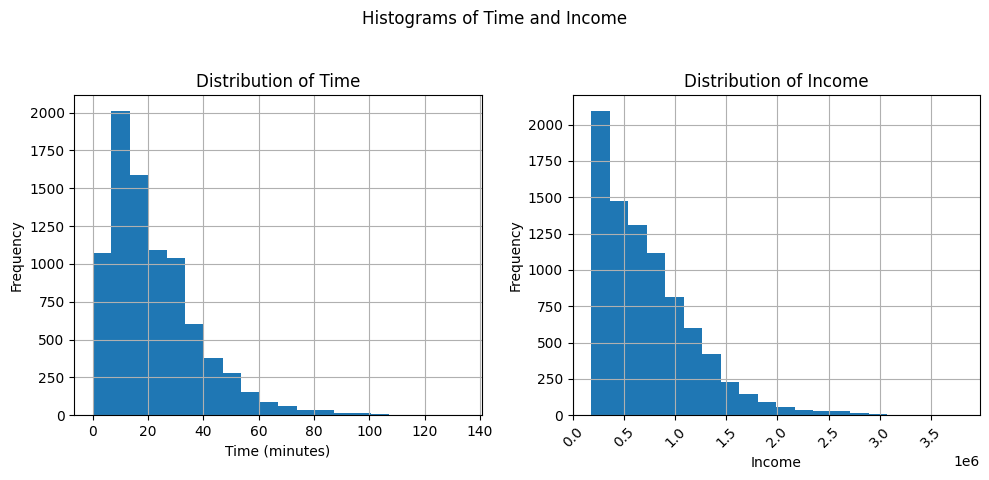

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
df['Time'].hist(bins=20, ax=ax[0])
ax[0].set_title('Distribution of Time')  # Title for the Time histogram
ax[0].set_xlabel('Time (minutes)')
ax[0].set_ylabel('Frequency')

df['Income'].hist(bins=20, ax=ax[1])
ax[1].set_title('Distribution of Income')  # Title for the Income histogram
ax[1].set_xlabel('Income')
ax[1].set_ylabel('Frequency')

plt.suptitle('Histograms of Time and Income')  # Overall title for the figure
plt.xticks(rotation=45)  # Apply rotation to all x-tick labels uniformly
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the suptitle

plt.show()

#Distribution of Labels in Train Dataset

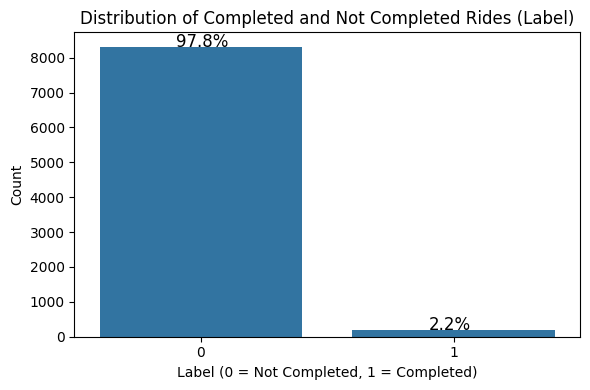

Percentage of each label:
Label
0    97.776471
1     2.223529
Name: proportion, dtype: float64


In [5]:


plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Label', data=df)
plt.title('Distribution of Completed and Not Completed Rides (Label)')
plt.xlabel('Label (0 = Not Completed, 1 = Completed)')
plt.ylabel('Count')

# Calculate the percentages and annotate the bars
total = len(df)  # Total number of data points
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)  # Calculate percentage
    x = p.get_x() + p.get_width() / 2 - 0.1  # X position of text
    y = p.get_y() + p.get_height()           # Y position of text
    ax.annotate(percentage, (x, y), size = 12)  # Show the percentage on the bar

plt.tight_layout()
plt.show()

# Display the percentage of each class
label_counts = df['Label'].value_counts(normalize=True) * 100
print("Percentage of each label:")
print(label_counts)

#Distribution of Completed Rides by Time Arrival and Income

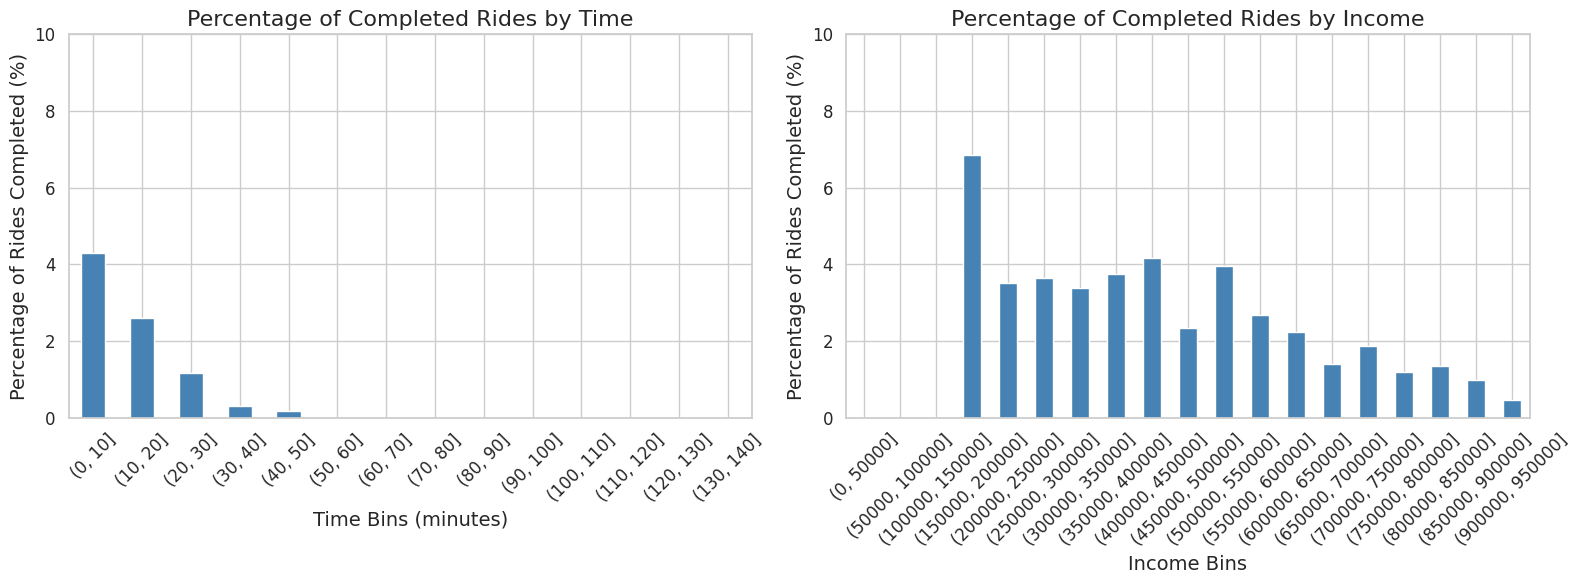

In [6]:
sns.set(style="whitegrid")

# Define bins for Time and Income as per your histogram bins
time_bins = range(0, 150, 10)  # Adjust the range and bin width to match your histogram
income_bins = range(0, 1000000, 50000)  # Adjust the range and bin width to match your histogram

# Cut the data into bins
df['Time_bin'] = pd.cut(df['Time'], bins=time_bins)
df['Income_bin'] = pd.cut(df['Income'], bins=income_bins)

# Calculate the percentage of rides completed in each bin
time_grouped = df.groupby('Time_bin')['Label'].mean() * 100
income_grouped = df.groupby('Income_bin')['Label'].mean() * 100

# Plotting
plt.figure(figsize=(16, 6))

# Time distribution plot
plt.subplot(1, 2, 1)
time_grouped.plot(kind='bar', color='steelblue')
plt.title('Percentage of Completed Rides by Time', fontsize=16)
plt.xlabel('Time Bins (minutes)', fontsize=14)
plt.ylabel('Percentage of Rides Completed (%)', fontsize=14)
plt.ylim(0, 10)  # Set the maximum y-value to 10
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Income distribution plot
plt.subplot(1, 2, 2)
income_grouped.plot(kind='bar', color='steelblue')
plt.title('Percentage of Completed Rides by Income', fontsize=16)
plt.xlabel('Income Bins', fontsize=14)
plt.ylabel('Percentage of Rides Completed (%)', fontsize=14)
plt.ylim(0, 10)  # Set the maximum y-value to 10
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Enhance layout
plt.tight_layout()
plt.show()


#Distribution of Rides by origin and Destination

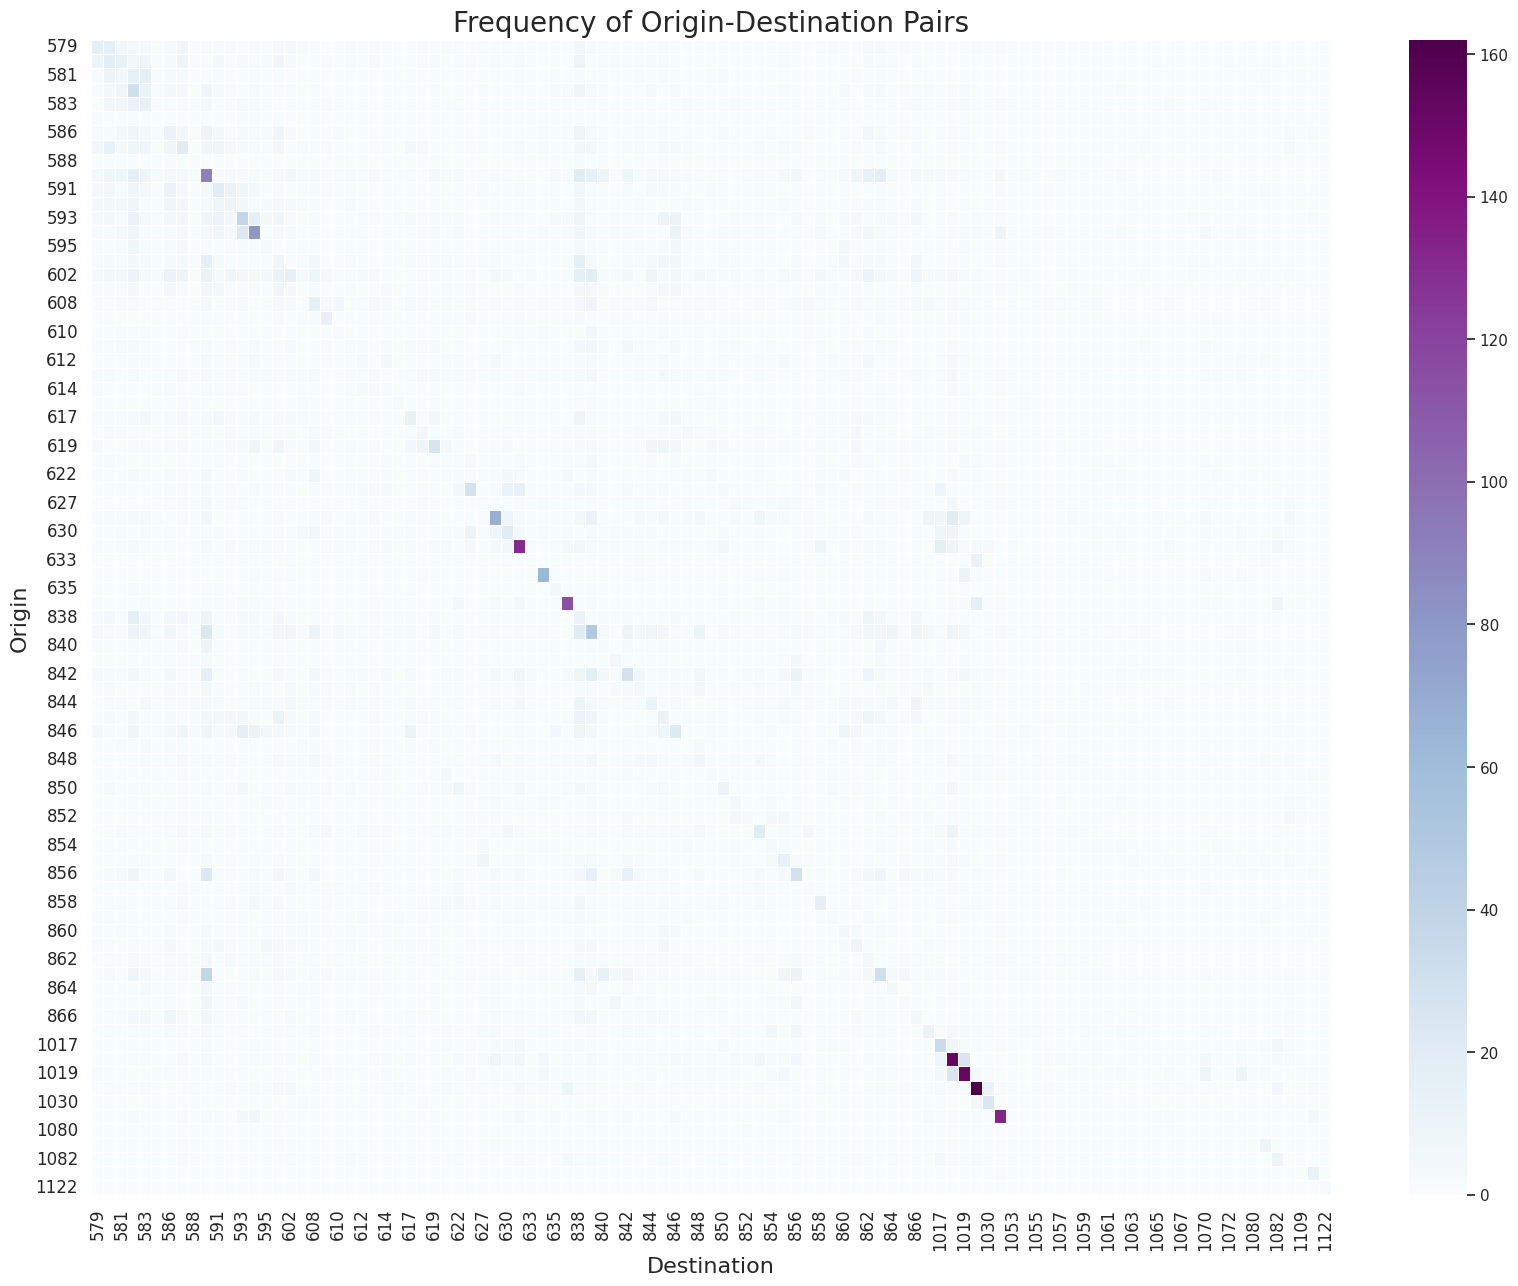

In [7]:
# Create a pivot table to count frequencies of each origin-destination pair
pivot_table = pd.crosstab(index=df['Origin'], columns=df['Destination'])

# Plotting
plt.figure(figsize=(20, 15))  # Adjust size based on your specific needs
sns.heatmap(pivot_table,  fmt="d", cmap="BuPu", linewidths=.5)
plt.title('Frequency of Origin-Destination Pairs', fontsize=20)
plt.xlabel('Destination', fontsize=16)
plt.ylabel('Origin', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

#Distribution of Rides by top 100 origins and Destinations

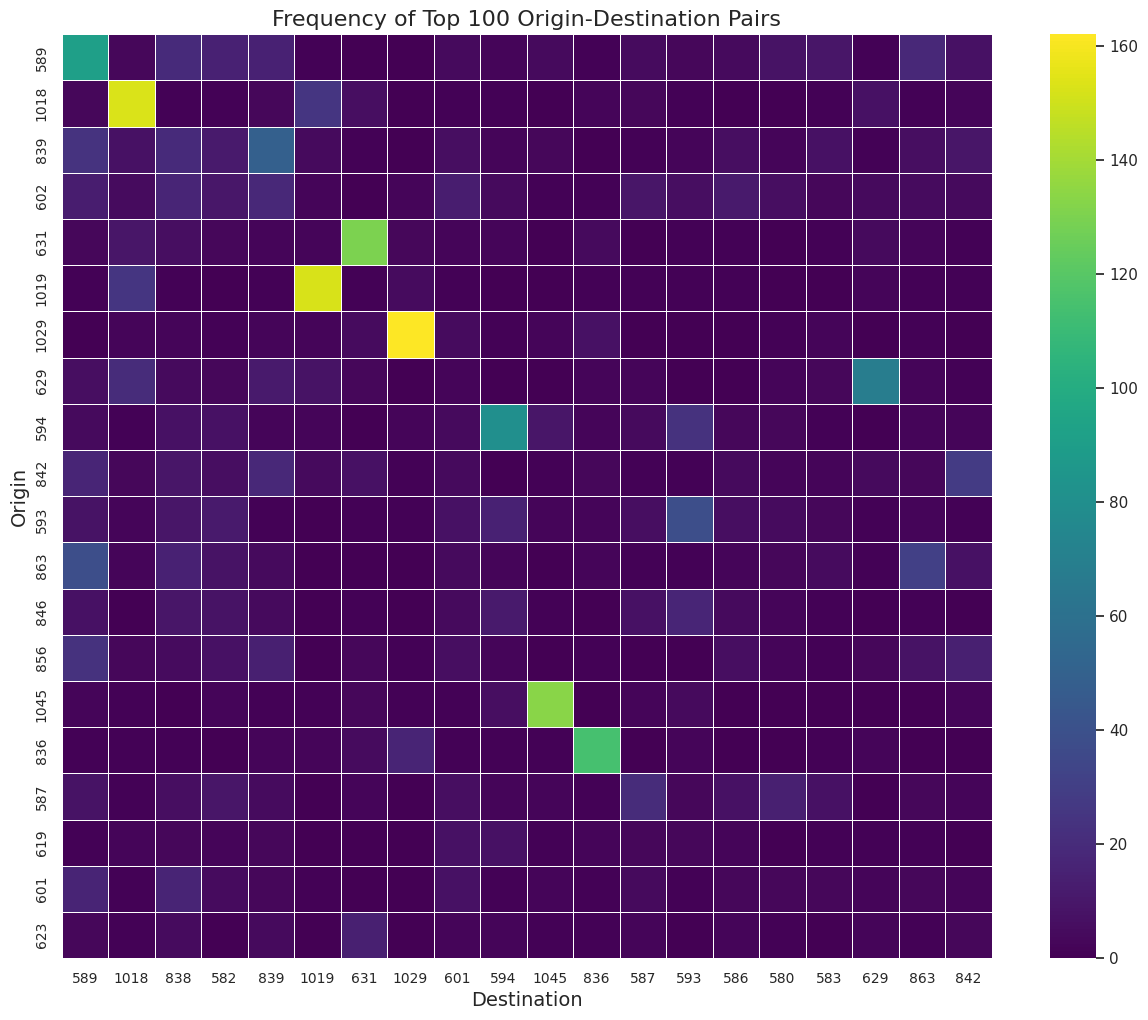

In [8]:
pivot_table = pd.crosstab(df['Origin'], df['Destination'])

# Focus only on top origins and destinations by overall frequency
top_origins = df['Origin'].value_counts().nlargest(20).index
top_destinations = df['Destination'].value_counts().nlargest(20).index

# Filter pivot table to include only top origins and destinations
filtered_pivot = pivot_table.loc[top_origins, top_destinations]

# Plotting
plt.figure(figsize=(15, 12))  # Adjusted for better fit
sns.heatmap(filtered_pivot, annot=False, cmap='viridis', linewidths=.5)
plt.title('Frequency of Top 100 Origin-Destination Pairs', fontsize=16)
plt.xlabel('Destination', fontsize=14)
plt.ylabel('Origin', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


#Adding Comment Embeddings to the Data

In [9]:

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased").to("cuda")

def get_bert_embeddings(texts):
    # Tokenize and prepare inputs
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128).to("cuda")
    with torch.no_grad():
        # Forward pass, get hidden states
        output = model(**encoded_input)

    # Extract embeddings from the last hidden state
    embeddings = output.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:

# Generate embeddings for all comments
comment_embeddings = get_bert_embeddings(df['Comment'].tolist())

# Example: Convert embeddings to DataFrame and concatenate
embed_df = pd.DataFrame(comment_embeddings)
df = pd.concat([df.reset_index(drop=True), embed_df.reset_index(drop=True)], axis=1)


#Adding time features to the Data - Hour and Day of week

In [11]:
# Extract day of the week and hour
df['Created_at'] = pd.to_datetime(df['Created_at'])

df['Day_of_Week'] = df['Created_at'].dt.dayofweek
df['Hour'] = df['Created_at'].dt.hour


In [12]:

# One-hot encode the day of the week
df_one_hot = pd.get_dummies(df['Day_of_Week'], prefix='Day')
df = pd.concat([df, df_one_hot], axis=1)


#Dropping Non Numerical Columns

In [13]:

# Convert columns with interval data to a numeric representation (if appropriate)
# Example: if you have bins, you might want to replace them with the midpoint of each bin
for column in df.columns:
    if pd.api.types.is_interval_dtype(df[column]):
        df[column] = df[column].map(lambda x: x.mid)

# Check and convert other non-numeric columns if necessary
for column in df.columns:
    if df[column].dtype not in [np.float64, np.int64, np.float32, np.int32,bool]:
        print(f"Column {column} is not numeric and is of type {df[column].dtype}")
        # Attempt to convert to numeric (this may throw an error if conversion is not appropriate)
        df[column] = pd.to_numeric(df[column], errors='coerce')

# Drop any columns that couldn't be converted
df = df.dropna(axis=1, how='all')


Column Comment is not numeric and is of type object
Column Created_at is not numeric and is of type datetime64[ns]
Column Time_bin is not numeric and is of type category
Column Income_bin is not numeric and is of type category


#Dropping Columns for Data Training

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Sample data preparation
# Assuming df is your DataFrame and 'target' is your target column
X = df.drop(['Label',"ID",	"UserID","Created_at","Unnamed: 0"], axis=1)

y = df['Label']



#Free GPU RAM

In [62]:
import torch

# Assuming `model` is your BERT model
del model  # Delete the model

# If you have an optimizer
# del optimizer

torch.cuda.empty_cache()  # Clear CUDA cache

# Optionally, check memory status
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 645835 KiB |   6679 MiB | 143665 MiB | 143034 MiB |
|       from large pool | 645344 KiB |   6679 MiB | 143474 MiB | 142844 MiB |
|       from small pool |    491 KiB |      2 MiB |    190 MiB |    190 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 645835 KiB |   6679 MiB | 143665 MiB | 143034 MiB |
|       from large pool | 645344 KiB |   6679 MiB | 143474 MiB |

#Installing Libraries

In [15]:
!pip install xgboost
!pip install hyperopt


#Initilizing XGB Parameters

In [63]:
import xgboost as xgb

# Parameters for using the GPU
gpu_params = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',  # This parameter enables GPU usage
    'predictor': 'gpu_predictor',
    'random_state': 42
}


#Seprating Training and Validation Datasets

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
weights_train = np.where(y_train == 1, 10, 1)
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights_train)
dval = xgb.DMatrix(X_val, label=y_val)


#Model Tuning

In [65]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score

# Define the search space for hyperparameters
space = {
    'max_depth': hp.choice('max_depth', range(3, 12)),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'device': 'cuda',  # Set device to CUDA
    'tree_method': 'hist'  # Use histogram-based method suitable for GPU
}

def objective(params):
    params['max_depth'] = int(params['max_depth'])

    # Train model
    evals_result = {}
    bst = xgb.train(params, dtrain, num_boost_round=200, evals=[(dtrain, 'train'), (dval, 'val')],
                    early_stopping_rounds=10, evals_result=evals_result, verbose_eval=False)
    pred_probs = bst.predict(dval)

    # Calculate ROC-AUC
    auc_score = roc_auc_score(y_val, pred_probs)

    return {'loss': 1-auc_score, 'status': STATUS_OK}

# Run the optimizer
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

print("Best Hyperparameters:", best)

100%|██████████| 200/200 [09:50<00:00,  2.95s/trial, best loss: 0.2775023370726495]
Best Hyperparameters: {'colsample_bytree': 0.7750628231984156, 'learning_rate': 0.08988967191849499, 'max_depth': 0, 'min_child_weight': 5.344319559816796, 'subsample': 0.5002376294196025}


#Training Model on All of Data (Training + Validation)

In [66]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Assuming the `best` dictionary is already obtained and dtrain has been defined
# Setup best parameters from Hyperopt output
best_params = {
    'max_depth': best['max_depth'] + 3,  # Adjusting for the range used in hp.choice
    'min_child_weight': best['min_child_weight'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'learning_rate': best['learning_rate'],
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'tree_method': 'hist',  # Using histogram-based method
    'device': 'cpu'       # Using GPU
}

best_params['max_depth'] = int(best_params['max_depth'])

weights = np.where(y == 1, 10, 1)
# Prepare the complete dataset DMatrix if not using the previously defined dtrain
data_dmatrix = xgb.DMatrix(data=X, label=y,weight=weights)

# Train the final model using the entire dataset
final_model = xgb.train(best_params, data_dmatrix, num_boost_round=200)



#Training the model on the training Data for finding the best thereshold

In [67]:

# Assuming the `best` dictionary is already obtained and dtrain has been defined
# Setup best parameters from Hyperopt output
best_params = {
    'max_depth': best['max_depth'] + 3,  # Adjusting for the range used in hp.choice
    'min_child_weight': best['min_child_weight'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'learning_rate': best['learning_rate'],
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'tree_method': 'hist',  # Using histogram-based method
    'device': 'cpu'       # Using GPU
}

best_params['max_depth'] = int(best_params['max_depth'])

weights = np.where(y == 1, 10, 1)
# Prepare the complete dataset DMatrix if not using the previously defined dtrain

# Train the final model using the entire dataset
tuned_model = xgb.train(best_params, dtrain, num_boost_round=200)



#Thereshold Optimization

In [71]:
from sklearn.metrics import f1_score, precision_recall_curve
y_probs = tuned_model.predict(dval)

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
# Remove NaN values
f1_scores = np.nan_to_num(f1_scores)

# Find the threshold that maximizes F1 score
opt_idx = np.argmax(f1_scores)
opt_threshold = thresholds[opt_idx]
opt_f1 = f1_scores[opt_idx]

print("Best Threshold:", opt_threshold)
print("Best F1-Score:", opt_f1)


Best Threshold: 0.4314022
Best F1-Score: 0.09090909090909091


<ipython-input-71-fc03d04fe72c>:8: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [72]:
# Apply the optimal threshold to convert probabilities into binary output
y_pred = (y_probs >= opt_threshold).astype(int)

# Evaluate the final predictions
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1664
           1       0.07      0.14      0.09        36

    accuracy                           0.94      1700
   macro avg       0.52      0.55      0.53      1700
weighted avg       0.96      0.94      0.95      1700



In [73]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_probs)

# Calculate the G-mean for each threshold: sqrt(TPR * (1 - FPR))
gmeans = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest G-mean
ix = np.argmax(gmeans)
opt_threshold = thresholds[ix]

print('Best Threshold=%f, G-Mean=%.3f' % (opt_threshold, gmeans[ix]))


Best Threshold=0.047901, G-Mean=0.657


In [74]:
# Apply the optimal threshold to convert probabilities into binary output
y_pred = (y_probs >= opt_threshold).astype(int)

# Evaluate the final predictions
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.56      0.71      1664
           1       0.04      0.78      0.07        36

    accuracy                           0.56      1700
   macro avg       0.51      0.67      0.39      1700
weighted avg       0.97      0.56      0.70      1700



#Loading the Test Data and Validating Model on the Test Data

In [75]:
test_df=pd.read_csv("task_test.csv")

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased").to("cuda")

# Generate embeddings for all comments
comment_embeddings = get_bert_embeddings(test_df['Comment'].tolist())

# Example: Convert embeddings to DataFrame and concatenate
embed_df = pd.DataFrame(comment_embeddings)
test_df = pd.concat([test_df.reset_index(drop=True), embed_df.reset_index(drop=True)], axis=1)

# Extract day of the week and hour
test_df['Created_at'] = pd.to_datetime(test_df['Created_at'])

test_df['Day_of_Week'] = test_df['Created_at'].dt.dayofweek
test_df['Hour'] = test_df['Created_at'].dt.hour

# One-hot encode the day of the week
df_one_hot = pd.get_dummies(test_df['Day_of_Week'], prefix='Day')
test_df = pd.concat([test_df, df_one_hot], axis=1)


X_test=test_df[X.columns]
y_test = test_df["Label"]

dtest = xgb.DMatrix(X_test, label=y_test)
pred_probs = final_model.predict(dtest)
final_auc = roc_auc_score(y_test, pred_probs)
print(f"Final Model AUC: {final_auc}")

# Saving the model to a file
final_model.save_model('final_xgboost_model.json')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Final Model AUC: 0.7165148160762943


#Ploting Confusion Matrix

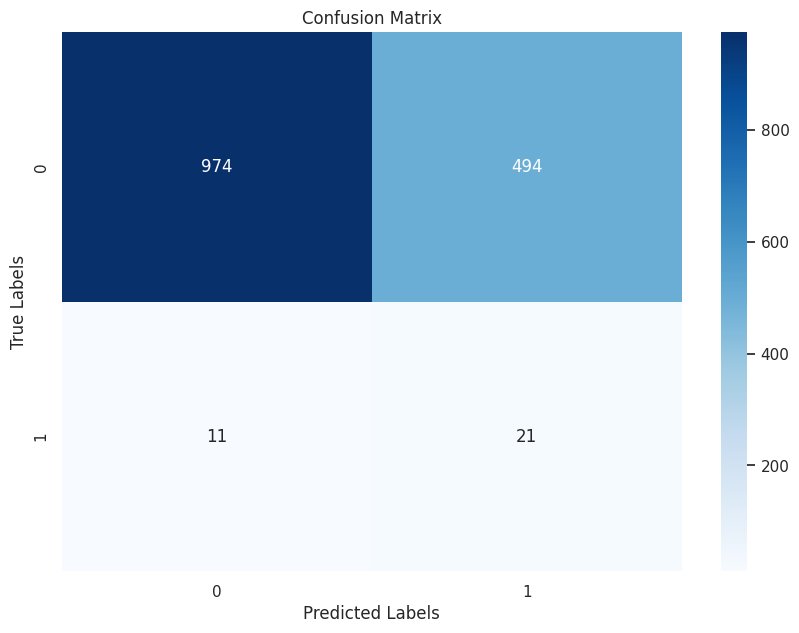

In [76]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and predictions are available
predictions=pred_probs>opt_threshold

# Step 1: Fit the Label Encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_test)  # Fit the encoder to the classes

# Optional: Transform your labels if necessary
# transformed_labels = label_encoder.transform(y_test)

# Step 2: Create Confusion Matrix
conf_mat = confusion_matrix(y_test, predictions)

# Step 3: Plot with correct class labels
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#Model Perfomance Report

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder


# 1. Print Classification Report in a DataFrame for Better Readability
report = classification_report(y_test, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)



              precision    recall  f1-score      support
0              0.988832  0.663488  0.794130  1468.000000
1              0.040777  0.656250  0.076782    32.000000
accuracy       0.663333  0.663333  0.663333     0.663333
macro avg      0.514805  0.659869  0.435456  1500.000000
weighted avg   0.968607  0.663333  0.778826  1500.000000


#Sample Misclassified Cases:

In [79]:
# 2. Identify Misclassifications
errors_index = np.where(y_test != predictions)[0]
misclassified_samples = test_df.iloc[errors_index]

# 3. Display Misclassified Samples in a structured DataFrame
print("\nSample Misclassified Cases:")
misclassified_samples = misclassified_samples[[i for i in misclassified_samples[2:] if (type(i) is not int) ]][misclassified_samples['Label'] == specific_class]

display(misclassified_samples[misclassified_samples.columns[2:]].head())



Sample Misclassified Cases:


,ID,UserID,Origin,Destination,Time,Income,Comment,Created_at,Label,Day_of_Week,Hour,Day_0,Day_1,Day_4,Day_5,Day_6
73,1009660,1003675,849,849,5,380000,همکاران راننده همیشه به دقت مسیر را بررسی میک...,2024-04-16 03:39:54.517000,1,1,3,False,True,False,False,False
168,1009968,1003488,602,591,15,750000,برای این سفر عالی، از راننده تلاشگرم سپاس گزا...,2024-04-16 18:44:36.271822,1,1,18,False,True,False,False,False
388,1009214,1003660,862,839,11,560000,برای این سفر عالی، از راننده تلاشگرم سپاس گزا...,2024-04-14 20:34:15.769090,1,6,20,False,False,False,False,True
624,1009956,1004274,582,593,34,920000,راننده عالی بود\n,2024-04-16 17:35:19.452806,1,1,17,False,True,False,False,False
700,1009025,1003455,629,843,19,550000,خوب\n,2024-04-14 09:51:55.462329,1,6,9,False,False,False,False,True


#Analysis of errors where true class is 1

In [80]:
# 4. Deep Dive into a Specific Error Type
specific_class = 1  # This is the class you're interested in
specific_errors = misclassified_samples[[i for i in misclassified_samples[2:] if (type(i) is not int) ]][misclassified_samples['Label'] == specific_class]
print(f"\nAnalysis of errors where true class is {specific_class}:")
display(specific_errors[specific_errors.columns[2:]].describe())



Analysis of errors where true class is 1:


,ID,UserID,Origin,Destination,Time,Income,Created_at,Label,Day_of_Week,Hour
count,1.100000e+01,1.100000e+01,11.000000,11.000000,11.000000,11.000000,11,11.0,11.000000,11.000000
mean,1.009437e+06,1.004081e+06,705.545455,772.181818,15.363636,552727.272727,2024-04-15 10:53:03.856362496,1.0,2.454545,12.363636
min,1.008779e+06,1.003455e+06,582.000000,591.000000,5.000000,270000.000000,2024-04-13 15:39:19.309730,1.0,0.000000,3.000000
25%,1.009120e+06,1.003668e+06,590.000000,616.000000,9.000000,445000.000000,2024-04-14 15:13:05.615709440,1.0,0.500000,7.000000
50%,1.009528e+06,1.004274e+06,608.000000,840.000000,15.000000,550000.000000,2024-04-15 13:43:10.390180096,1.0,1.000000,13.000000
75%,1.009745e+06,1.004407e+06,846.000000,845.000000,19.000000,625000.000000,2024-04-16 07:40:32.774119936,1.0,5.500000,17.500000
max,1.009968e+06,1.004617e+06,1017.000000,1017.000000,34.000000,920000.000000,2024-04-16 18:44:36.271822,1.0,6.000000,20.000000
std,4.173506e+02,4.394407e+02,155.756453,143.050214,8.523764,185854.292880,NaN,0.0,2.659460,6.217278


#Feature Importance

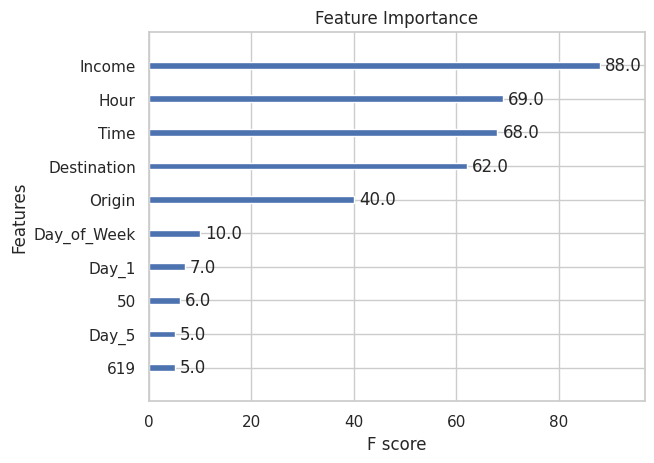

In [81]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming 'model' is your trained XGBoost model
xgb.plot_importance(final_model, max_num_features=10)  # Show top 10 features
plt.title('Feature Importance')
plt.show()


In [87]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.3 MB/s eta 0:00:00


#SHAP Values















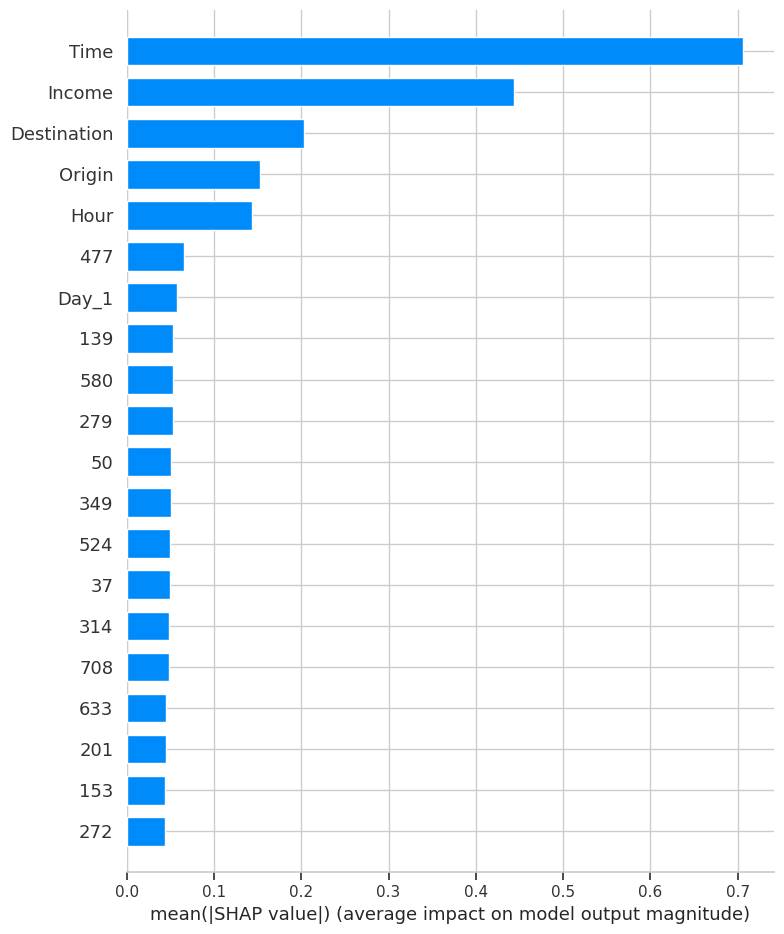

In [89]:
import shap

# Initialize JS visualization code
shap.initjs()

# Create object that can calculate shap values
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)

# Plot summary plot for all features
shap.summary_plot(shap_values, X, plot_type="bar")
